In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from ssm.models import HMM
from ssm.util import one_hot, find_permutation

from hips.plotting.colormaps import gradient_cmap, white_to_color_cmap
import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

#data format library
import h5py
from scipy.io import loadmat

%matplotlib inline

npr.seed(0)

In [121]:
###ICA signal
f = h5py.File('/home/kschen/github/local-linear-segmentation/AML32_moving.hdf5','r')  #GCamp6s
#f = h5py.File('/home/kschen/github/local-linear-segmentation/AML18_moving.hdf5','r')  #GFP
#f = h5py.File('/home/kschen/github/local-linear-segmentation/AML32_immobilized.hdf5','r')  #GCamp6s immobalized

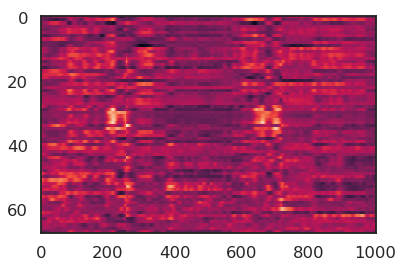

In [122]:
###neural
#neu = np.array(f['BrainScanner20171017_170419']['Neurons']['Activity'])  #immobalized
neu = np.array(f['BrainScanner20170424_105620']['Neurons']['Activity'])  #moving
neu = neu[:,500:]  #remove initial
plt.imshow(neu[:,1000:2000],aspect="auto")

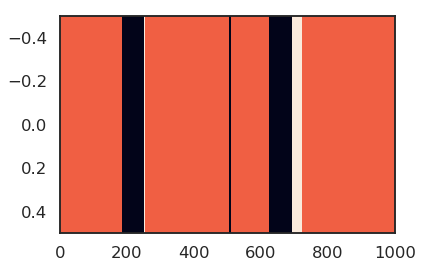

In [123]:
###behavioral
beh = np.array(f['BrainScanner20170424_105620']['Behavior']['Ethogram'])  #moving
beh = beh[500:]  #remove initial
plt.imshow(beh[1000:2000][None,:],aspect="auto")
ethos = len(np.unique(beh))

In [124]:
C = np.cov(neu)
u,s,v = np.linalg.svd(C)
eV = u[:,:3]
PCs = (eV.T @ neu).T

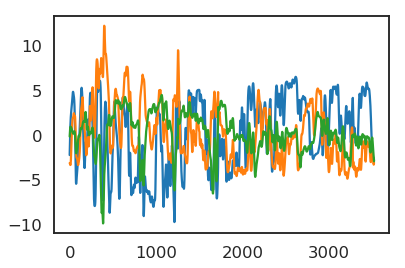

In [125]:
plt.plot(PCs);

In [144]:
# Now create a new HMM and fit it to the data with EM
T = PCs.shape[0]
K = ethos    # number of discrete states
D = 3    # data dimension
M = 3    # input dimension

N_iters = 50
#hmm = HMM(K, D, M, 
#          observations="gaussian",# observation_kwargs=dict(C=C),
#          transitions="inputdriven")
hmm = HMM(K,D, transitions="sticky", 
          observations="t")

inpt = np.zeros(PCs.shape)
# Fit
hmm_lps = hmm.fit(PCs, inputs=inpt, method="em", num_em_iters=N_iters)

/home/kschen/.local/lib/python3.7/site-packages/ssm-0.0.1-py3.7-linux-x86_64.egg/ssm/util.py:258: UserWarning: generalized_newton_studentst_dof fixed point grew beyond bounds [0.001,20].
  "bounds [{},{}].".format(nu_min, nu_max))
/home/kschen/.local/lib/python3.7/site-packages/ssm-0.0.1-py3.7-linux-x86_64.egg/ssm/util.py:258: UserWarning: generalized_newton_studentst_dof fixed point grew beyond bounds [0.001,20].
  "bounds [{},{}].".format(nu_min, nu_max))
/home/kschen/.local/lib/python3.7/site-packages/ssm-0.0.1-py3.7-linux-x86_64.egg/ssm/util.py:258: UserWarning: generalized_newton_studentst_dof fixed point grew beyond bounds [0.001,20].
  "bounds [{},{}].".format(nu_min, nu_max))
/home/kschen/.local/lib/python3.7/site-packages/ssm-0.0.1-py3.7-linux-x86_64.egg/ssm/util.py:258: UserWarning: generalized_newton_studentst_dof fixed point grew beyond bounds [0.001,20].
  "bounds [{},{}].".format(nu_min, nu_max))
/home/kschen/.local/lib/python3.7/site-packages/ssm-0.0.1-py3.7-linux-x86_64

Text(0, 0.5, 'Log Probability')

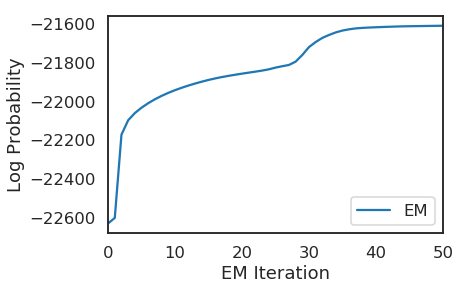

In [127]:
# Plot the log probabilities of the true and fit models
plt.plot(hmm_lps, label="EM")
plt.legend(loc="lower right")
plt.xlabel("EM Iteration")
plt.xlim(0, N_iters)
plt.ylabel("Log Probability")


([], <a list of 0 Text yticklabel objects>)

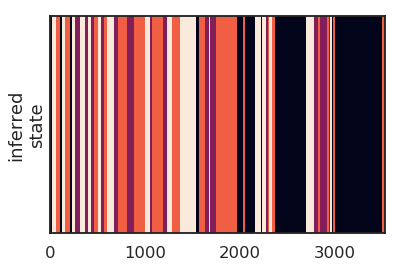

In [128]:
z_inf = hmm.most_likely_states(PCs, input=inpt)

plt.imshow(z_inf[None, :], aspect="auto")
plt.xlim(0, T)
plt.ylabel("inferred\nstate")
plt.yticks([])

In [129]:
np.unique(z_inf)

array([0, 1, 2, 3])

In [130]:
def mapping(beh,n):
    ids = np.unique(beh)
    new_id = np.roll(ids,n)  #rotate
    nbeh = np.squeeze(np.array([new_id[np.where(ii==ids)] for ii in beh]))
    return nbeh

In [140]:
nbeh = mapping(beh,4)

In [141]:
nbeh.shape

(3526,)

([], <a list of 0 Text yticklabel objects>)

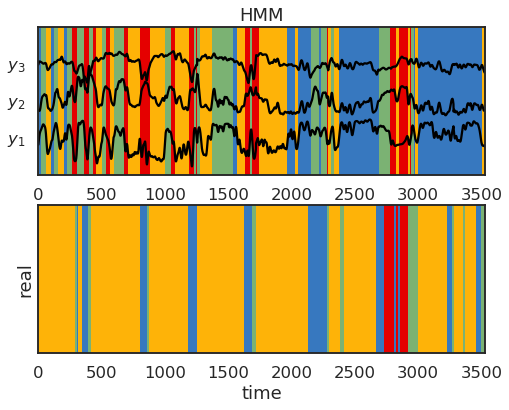

In [142]:
# Plot the data and the smoothed data
lim = 1.05 * abs(PCs).max()
plt.figure(figsize=(8, 6))
plt.subplot(211)
plt.imshow(z_inf[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1, extent=(0, T, -lim, (D)*lim))

for d in range(D):
    plt.plot(PCs[:,d] + lim * d, '-k')

plt.xlim(0, T)
plt.xlabel("time")
plt.yticks(lim * np.arange(D), ["$y_{}$".format(d+1) for d in range(D)])

plt.title('HMM')

#real behavior
#plt.figure(figsize=(8, 2))
plt.subplot(212)
plt.imshow(nbeh[None,:]+1, aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1, extent=(0, T, -lim, (D)*lim))
plt.xlabel("time")
plt.ylabel('real')
plt.yticks([])

Text(0.5, 1.0, 'HMM')

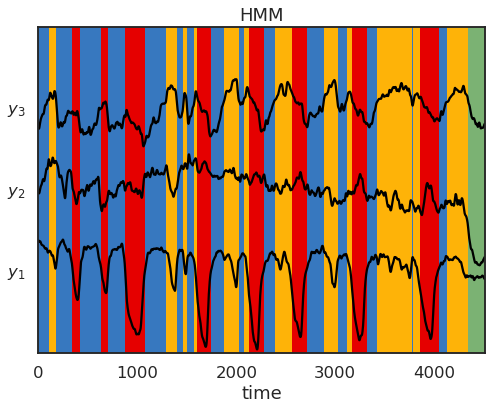

In [120]:
###w/o behavior

lim = 1.05 * abs(PCs).max()
plt.figure(figsize=(8, 6))
plt.imshow(z_inf[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1, extent=(0, T, -lim, (D)*lim))

for d in range(D):
    plt.plot(PCs[:,d] + lim * d, '-k')

plt.xlim(0, T)
plt.xlabel("time")
plt.yticks(lim * np.arange(D), ["$y_{}$".format(d+1) for d in range(D)])

plt.title('HMM')